In [129]:
!pip install prophet


## 1. Import libraries

In [130]:
#import needed libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot



## 2. Uploading and preparing the data 

In [131]:
#Load the data train and test
#note we are using standardized data from pre_processing_data.
train_data = pd.read_csv('pre_processing_data/train_data.csv')
test_data = pd.read_csv('pre_processing_data/test_data.csv')


In [132]:
#Converting 'Txn_date' of train_data to datetime 
train_data['Txn_date'] = pd.to_datetime(train_data['Txn_date'])


In [133]:
#resampling and aggregating the data for total sales 
train_data = train_data.set_index('Txn_date')

#resampling the data to daily
total_sales_train_data = train_data.resample('D')['Total_Amt'].sum()

#resetting index
total_sales_train_data = total_sales_train_data.reset_index()

#renaming the columns
total_sales_train_data.columns = ['ds', 'y']


In [134]:
#Converting 'Txn_date' test_data to datetime 
test_data['Txn_date'] = pd.to_datetime(test_data['Txn_date'])

In [135]:
#resampling and aggregating the data for total sales 
test_data = test_data.set_index('Txn_date')

#resampling the data to daily
total_sales_test_data = test_data.resample('D')['Total_Amt'].sum()

#resetting index
total_sales_test_data = total_sales_test_data.reset_index()

#renaming the columns
total_sales_test_data.columns = ['ds', 'y']

In [136]:
test_data.head()

,Invoice_id,Cust_id,Product_Sub_category,Qty,Rate,Tax,Total_Amt,Store_type,Product_Category_Books,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Footwear,Product_Category_Home and kitchen
Txn_date,,,,,,,,,,,,,
2018-02-20,-1.437464,-1.743252,Mens,-1.404599,0.213316,-0.840241,-0.840241,e-Shop,0,1,0,0,0
2018-09-02,-1.141048,-1.743252,Non-fiction,-0.698246,0.131009,-0.376994,-0.376994,e-Shop,1,0,0,0,0
2018-01-08,1.374135,-1.742430,Women,0.008108,-1.391676,-0.985404,-0.985404,TeleShop,0,0,0,0,0
2018-02-13,0.779040,-1.742430,Women,1.420815,-0.892991,-0.151442,-0.151442,Brick and Mortar,0,0,0,1,0
2018-12-02,1.343703,-1.741197,Women,-1.404599,0.985553,-0.655752,-0.655752,e-Shop,0,0,0,1,0


In [137]:
train_data.head()


,Invoice_id,Cust_id,Product_Sub_category,Qty,Rate,Tax,Total_Amt,Store_type,Product_Category_Books,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Footwear,Product_Category_Home and kitchen
Txn_date,,,,,,,,,,,,,
2016-09-23,-0.834206,-1.743252,Women,0.714462,1.307519,1.713115,1.713115,e-Shop,0,0,0,1,0
2017-10-21,1.670769,-1.743252,Mens,0.008108,-1.665227,-1.181460,-1.181460,TeleShop,0,1,0,0,0
2017-04-12,-0.474639,-1.742841,Mobiles,-0.698246,-1.406201,-1.111481,-1.111481,Brick and Mortar,0,0,1,0,0
2017-08-23,0.143936,-1.742841,Non-fiction,0.008108,1.234895,0.897082,0.897082,TeleShop,1,0,0,0,0
2017-09-09,-0.798411,-1.742841,Fiction,1.420815,-1.464300,-0.833879,-0.833879,e-Shop,1,0,0,0,0


In [138]:
print(total_sales_train_data.head())
print(total_sales_test_data.head())


          ds         y
0 2016-01-02  0.583113
1 2016-01-03  1.006711
2 2016-01-04  5.441140
3 2016-01-05  2.083814
4 2016-01-06 -0.934934
          ds         y
0 2018-01-01 -3.740363
1 2018-01-02 -1.758408
2 2018-01-03 -7.947848
3 2018-01-04  0.437700
4 2018-01-05 -4.238147


## 3. Train and Prophet model


In [139]:
#Modeling for total sales
#total_sales_train_data_model = Prophet(interval_width=0.75, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.05)
total_sales_train_data_model = Prophet(interval_width=0.75, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.05, n_changepoints=50)
total_sales_train_data_model.add_country_holidays(country_name='US')
total_sales_train_data_model.fit(total_sales_train_data)

14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing


## 4. Future predictions 365

In [140]:
#Forecasting for total sales
total_sales_data_forecast = total_sales_train_data_model.make_future_dataframe(periods=365, freq='D')
total_sales_data_forecast = total_sales_train_data_model.predict(total_sales_data_forecast)

## 5. Plotting the results for the total sales forecast 

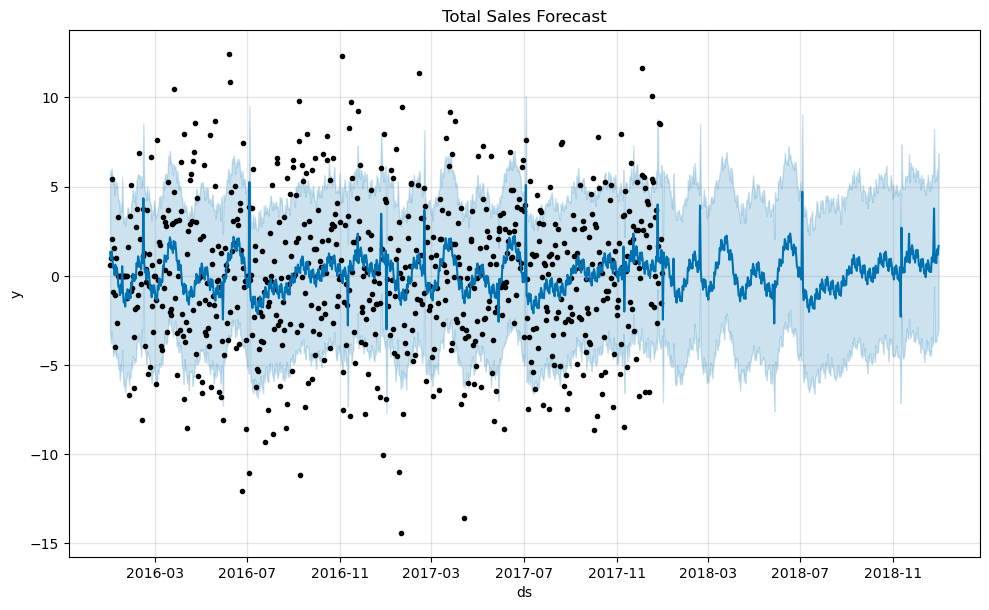

In [141]:
# Plotting the results for total sales
fig1 = total_sales_train_data_model.plot(total_sales_data_forecast)
plt.title('Total Sales Forecast')
plt.show()


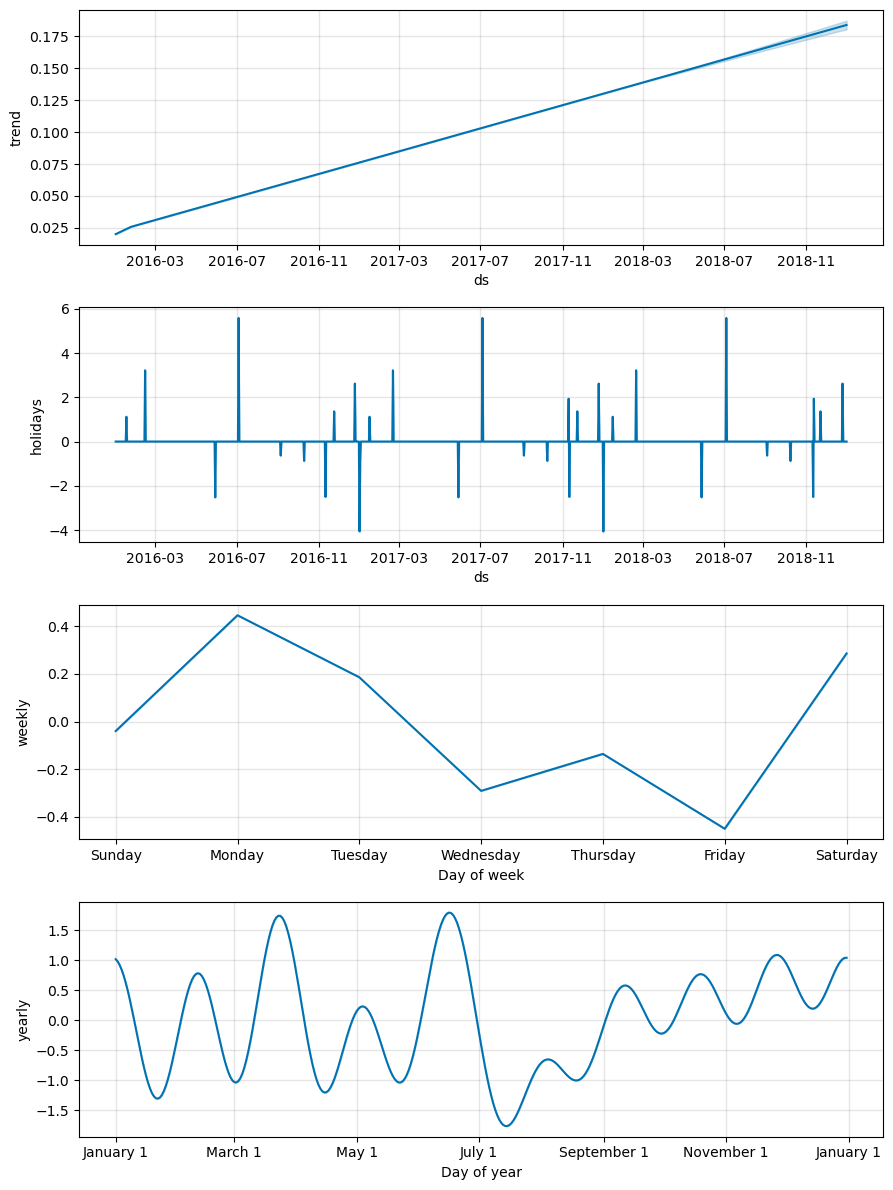

In [142]:
fig2 = total_sales_train_data_model.plot_components(total_sales_data_forecast)
plt.show()

## 6. Cross validation and additional metrics

In [143]:
#prep for cross validation
total_days = len(total_sales_train_data)
total_days

730

In [144]:
max_init = total_days - 365
max_init

365

In [145]:
# Seting the training period to 365 days and keeping horizon at 365 days
total_sales_cv = cross_validation(total_sales_train_data_model, initial='364 days', period='360 days', horizon='365 days')

# Calculating performance metrics for each horizon
df_p = performance_metrics(total_sales_cv)
print(df_p)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

14:12:50 - cmdstanpy - INFO - Chain [1] start processing
14:12:50 - cmdstanpy - INFO - Chain [1] done processing


     horizon        mse      rmse       mae      mape     mdape     smape  \
0    36 days  33.823508  5.815798  4.620844  3.286013  1.568420  1.493397   
1    37 days  31.508209  5.613217  4.422705  3.384256  1.573503  1.493397   
2    38 days  32.128963  5.668242  4.509342  3.106731  1.573503  1.493397   
3    39 days  32.671639  5.715911  4.556284  3.067881  1.568420  1.493397   
4    40 days  32.402659  5.692333  4.501251  2.998288  1.556285  1.456467   
..       ...        ...       ...       ...       ...       ...       ...   
325 361 days  21.626474  4.650427  3.700075  3.705301  0.801912  1.259925   
326 362 days  22.147628  4.706127  3.786782  3.700533  0.801912  1.265747   
327 363 days  22.964993  4.792180  3.903148  3.789890  0.862459  1.310012   
328 364 days  21.783517  4.667282  3.782749  3.762469  0.862459  1.276470   
329 365 days  21.976438  4.687903  3.806648  4.389109  0.862459  1.289342   

     coverage  
0    0.583333  
1    0.611111  
2    0.583333  
3    0.5833

## 7.Dummy Forecast

In [146]:
last_observed_value = total_sales_train_data['y'].iloc[-1]
dummy_forecast = np.full_like(total_sales_test_data['ds'], last_observed_value, dtype=np.float)

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_28783/2802656380.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dummy_forecast = np.full_like(total_sales_test_data['ds'], last_observed_value, dtype=np.float)


In [147]:
historical_avg_value = total_sales_train_data['y'].mean()
historical_avg = np.full_like(total_sales_test_data['ds'], historical_avg_value, dtype=np.float)

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_28783/86478701.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  historical_avg = np.full_like(total_sales_test_data['ds'], historical_avg_value, dtype=np.float)


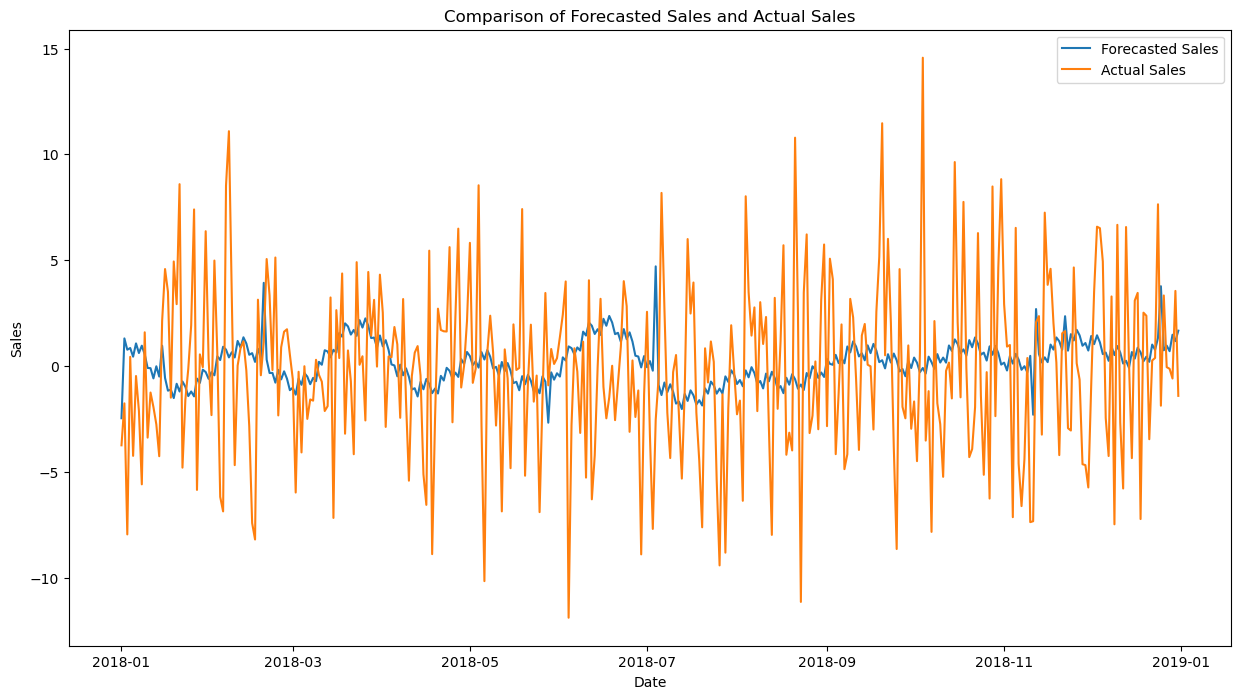

In [148]:
forecasted_sales = total_sales_data_forecast[total_sales_data_forecast['ds'].isin(total_sales_test_data['ds'])]
merged_data = forecasted_sales[['ds', 'yhat']].merge(total_sales_test_data, on='ds', how='left')
merged_data.columns = ['Date', 'Forecasted Sales', 'Actual Sales']

plt.figure(figsize=(15, 8))
plt.plot(merged_data['Date'], merged_data['Forecasted Sales'], label='Forecasted Sales')
plt.plot(merged_data['Date'], merged_data['Actual Sales'], label='Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Forecasted Sales and Actual Sales')
plt.legend()
plt.show()


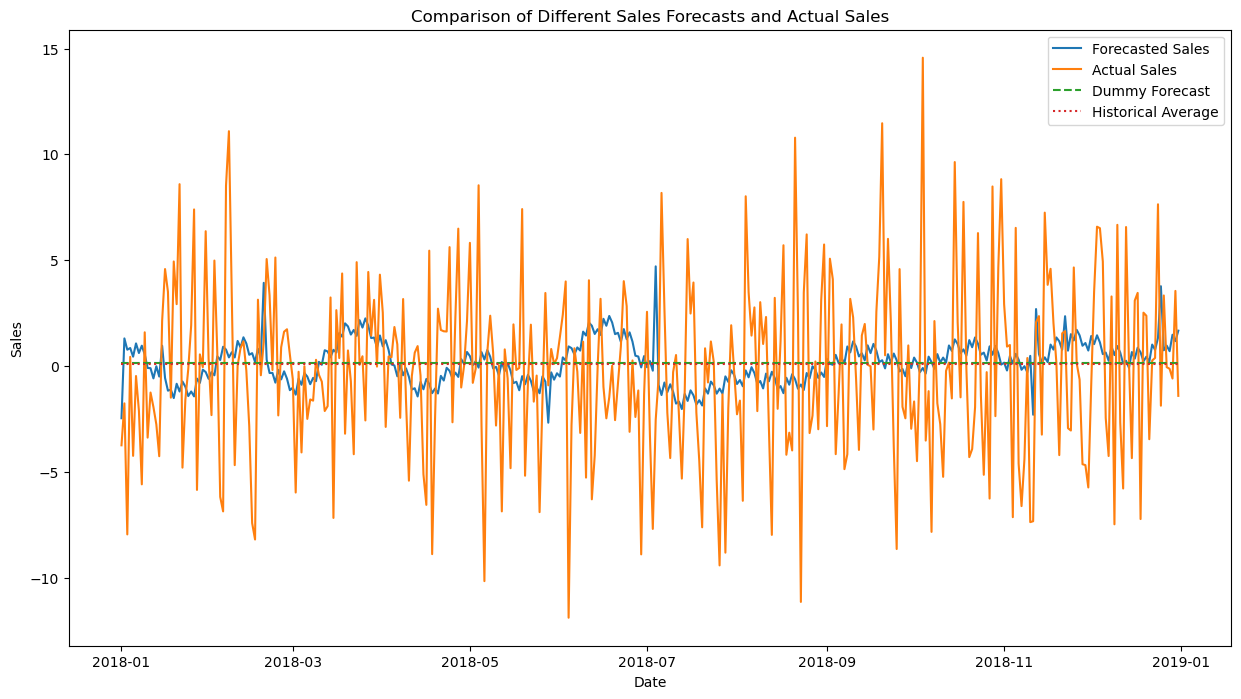

In [149]:
last_day_sales = total_sales_train_data['y'].iloc[-1]
merged_data['Dummy Forecast'] = last_day_sales

# Creating the Historical Average Forecast
historical_avg_sales = total_sales_train_data['y'].mean()
merged_data['Historical Average'] = historical_avg_sales

# Plotting all forecasts and actual sales
plt.figure(figsize=(15, 8))
plt.plot(merged_data['Date'], merged_data['Forecasted Sales'], label='Forecasted Sales')
plt.plot(merged_data['Date'], merged_data['Actual Sales'], label='Actual Sales')
plt.plot(merged_data['Date'], merged_data['Dummy Forecast'], label='Dummy Forecast', linestyle='--')
plt.plot(merged_data['Date'], merged_data['Historical Average'], label='Historical Average', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Different Sales Forecasts and Actual Sales')
plt.legend()
plt.show()

In [150]:
#Functions for calculating MAE, RMSE, and MAPE
# Function to calculate MAE
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

# Function to calculate RMSE
def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Function to calculate MAPE
def mean_absolute_percentage_error(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Calculating error metrics for Forecasted Sales
mae_forecast = mean_absolute_error(merged_data['Actual Sales'], merged_data['Forecasted Sales'])
rmse_forecast = root_mean_squared_error(merged_data['Actual Sales'], merged_data['Forecasted Sales'])
mape_forecast = mean_absolute_percentage_error(merged_data['Actual Sales'], merged_data['Forecasted Sales'])

# Calculating error metrics for Dummy Forecast
mae_dummy = mean_absolute_error(merged_data['Actual Sales'], merged_data['Dummy Forecast'])
rmse_dummy = root_mean_squared_error(merged_data['Actual Sales'], merged_data['Dummy Forecast'])
mape_dummy = mean_absolute_percentage_error(merged_data['Actual Sales'], merged_data['Dummy Forecast'])

# Calculating error metrics for Historical Average Forecast
mae_historical = mean_absolute_error(merged_data['Actual Sales'], merged_data['Historical Average'])
rmse_historical = root_mean_squared_error(merged_data['Actual Sales'], merged_data['Historical Average'])
mape_historical = mean_absolute_percentage_error(merged_data['Actual Sales'], merged_data['Historical Average'])

(mae_forecast, rmse_forecast, mape_forecast), (mae_dummy, rmse_dummy, mape_dummy), (mae_historical, rmse_historical, mape_historical)


((3.3338288147936446, 4.230059456212683, 254.67272454440894),
 (3.2153952468389857, 4.148759587873033, 124.59665329448232),
 (3.2097573249408664, 4.143429620689789, 112.55521759394469))

In [151]:
print('MAE:', mae_forecast)
print('RMSE:', rmse_forecast)
print('MAPE:', mape_forecast)


MAE: 3.3338288147936446
RMSE: 4.230059456212683
MAPE: 254.67272454440894


## Test for a category forecast


In [152]:
electronics_sales = train_data[(train_data['Product_Category_Electronics'] == 1)]
electronics_sales.head()

,Invoice_id,Cust_id,Product_Sub_category,Qty,Rate,Tax,Total_Amt,Store_type,Product_Category_Books,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Footwear,Product_Category_Home and kitchen
Txn_date,,,,,,,,,,,,,
2017-04-12,-0.474639,-1.742841,Mobiles,-0.698246,-1.406201,-1.111481,-1.111481,Brick and Mortar,0,0,1,0,0
2017-11-09,-0.263291,-1.738730,Audio and video,-0.698246,-1.103601,-0.966897,-0.966897,Brick and Mortar,0,0,1,0,0
2017-11-27,1.567631,-1.738730,Personal Appliances,0.714462,0.634536,1.070005,1.070005,TeleShop,0,0,1,0,0
2017-11-03,-0.391226,-1.736675,Computers,1.420815,1.242158,2.399022,2.399022,Brick and Mortar,0,0,1,0,0
2016-10-27,0.503031,-1.733386,Cameras,-1.404599,-0.752584,-1.070997,-1.070997,e-Shop,0,0,1,0,0


In [153]:
electronics_sales_prophet = electronics_sales.reset_index().rename(columns={'Txn_date': 'ds', 'Total_Amt': 'y'})
electronics_sales_prophet
#taking onlu Txn_date, Total_Amt columns
electronics_sales_prophet = electronics_sales_prophet[['ds', 'y']]
electronics_sales_prophet.head()

,ds,y
0,2017-04-12,-1.111481
1,2017-11-09,-0.966897
2,2017-11-27,1.070005
3,2017-11-03,2.399022
4,2016-10-27,-1.070997


In [154]:
electronics_sales_prophet['ds'] = pd.to_datetime(electronics_sales_prophet['ds'])
electronics_sales_daily = electronics_sales_prophet.groupby('ds').sum().reset_index()
electronics_sales_daily.head()


,ds,y
0,2016-01-02,2.257161
1,2016-01-03,-1.918179
2,2016-01-04,1.326950
3,2016-01-05,-2.712567
4,2016-01-06,-0.523645


In [155]:
electronics_sales_model = Prophet(interval_width=0.75, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True,  changepoint_range=0.8, changepoint_prior_scale=0.05, n_changepoints=50)

In [156]:
electronics_sales_model.add_country_holidays(country_name='US')

In [157]:
electronics_sales_model.fit(electronics_sales_daily)
future_dates = electronics_sales_model.make_future_dataframe(periods=365)
forecast = electronics_sales_model.predict(future_dates)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

14:12:51 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing


             ds      yhat  yhat_lower  yhat_upper
1057 2018-12-27  0.575367   -1.744086    2.839292
1058 2018-12-28  0.154392   -2.232725    2.352830
1059 2018-12-29  0.412208   -1.890075    2.781678
1060 2018-12-30  0.248285   -2.128615    2.589458
1061 2018-12-31  0.085996   -2.165680    2.477884


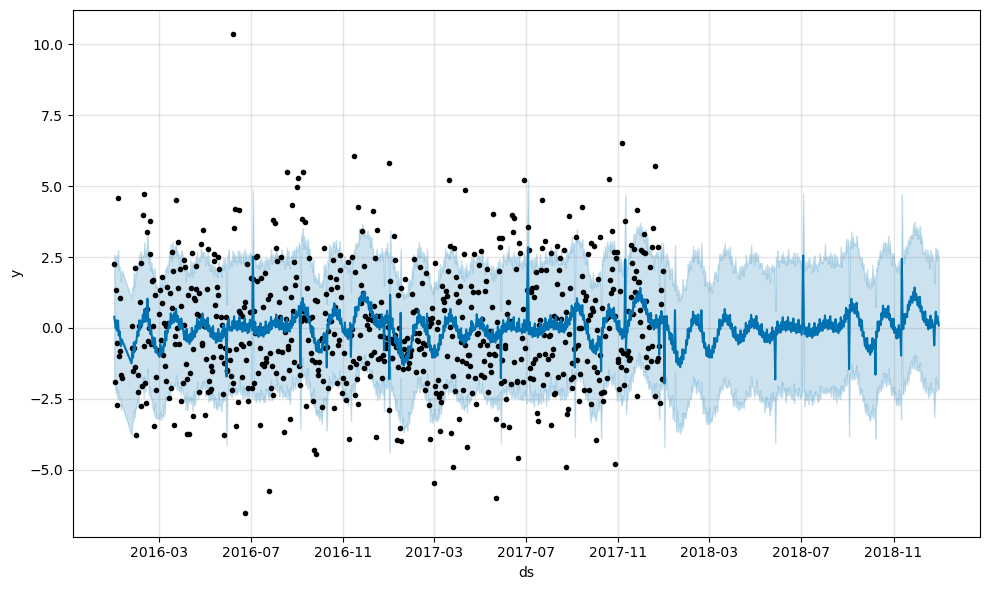

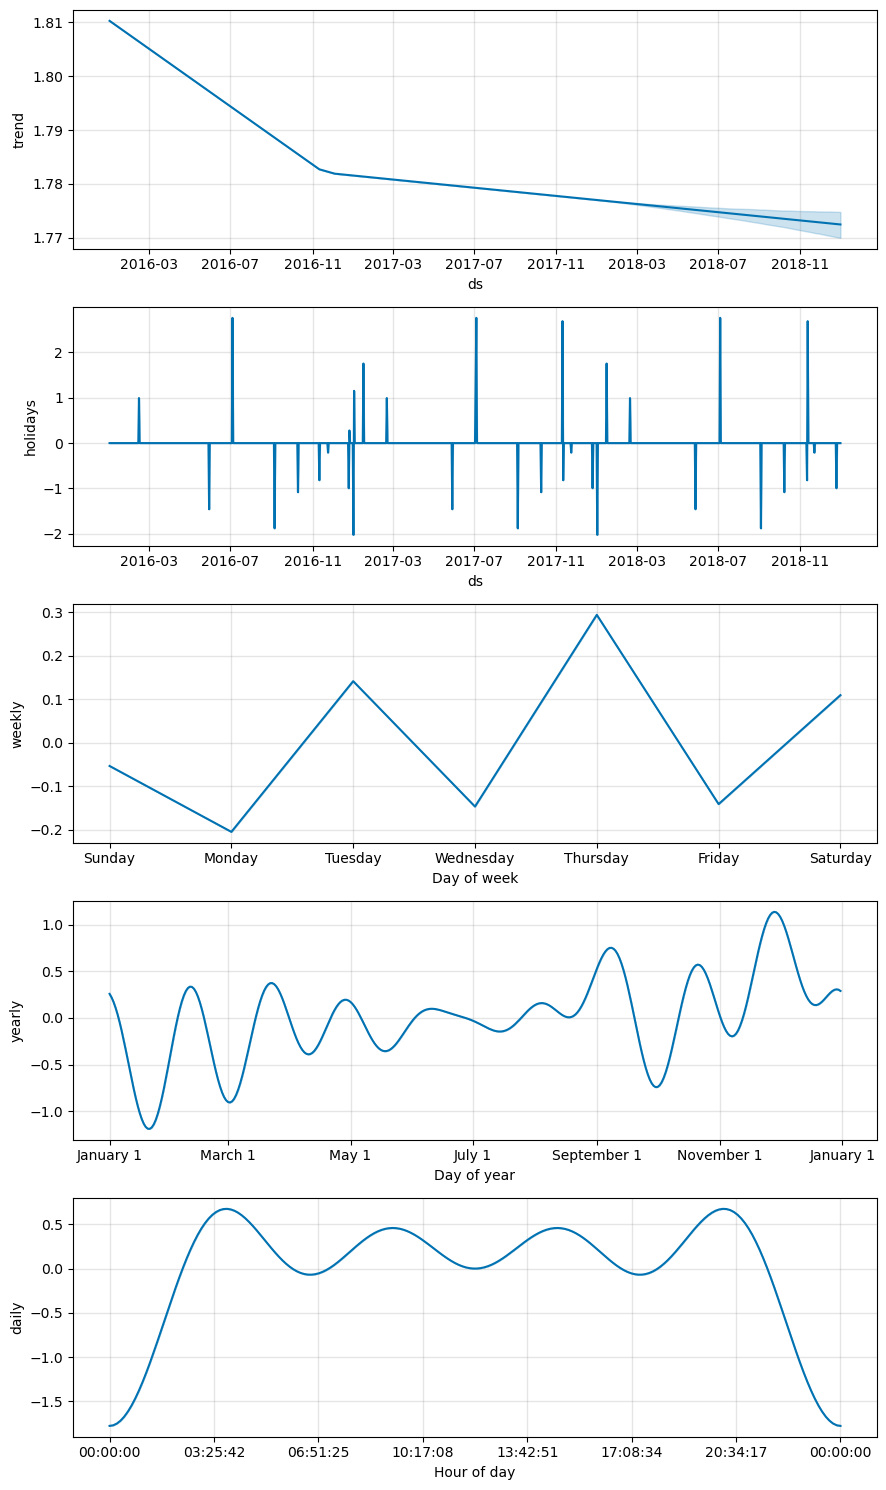

In [159]:
fig1 = electronics_sales_model.plot(forecast)
fig2 = electronics_sales_model.plot_components(forecast)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

14:14:31 - cmdstanpy - INFO - Chain [1] start processing
14:14:31 - cmdstanpy - INFO - Chain [1] done processing


     horizon        mse      rmse       mae      mape     mdape     smape  \
0    36 days  33.823508  5.815798  4.620844  3.286013  1.568420  1.493397   
1    37 days  31.508209  5.613217  4.422705  3.384256  1.573503  1.493397   
2    38 days  32.128963  5.668242  4.509342  3.106731  1.573503  1.493397   
3    39 days  32.671639  5.715911  4.556284  3.067881  1.568420  1.493397   
4    40 days  32.402659  5.692333  4.501251  2.998288  1.556285  1.456467   
..       ...        ...       ...       ...       ...       ...       ...   
325 361 days  21.626474  4.650427  3.700075  3.705301  0.801912  1.259925   
326 362 days  22.147628  4.706127  3.786782  3.700533  0.801912  1.265747   
327 363 days  22.964993  4.792180  3.903148  3.789890  0.862459  1.310012   
328 364 days  21.783517  4.667282  3.782749  3.762469  0.862459  1.276470   
329 365 days  21.976438  4.687903  3.806648  4.389109  0.862459  1.289342   

     coverage  
0    0.583333  
1    0.611111  
2    0.583333  
3    0.5833

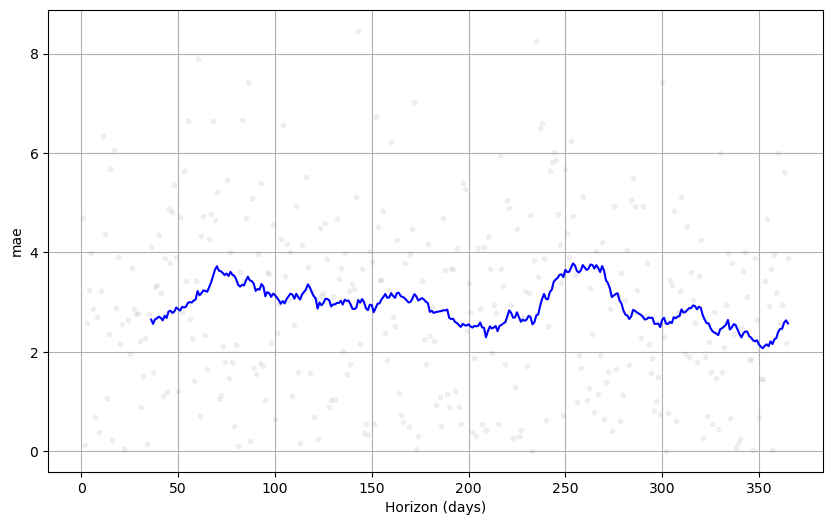

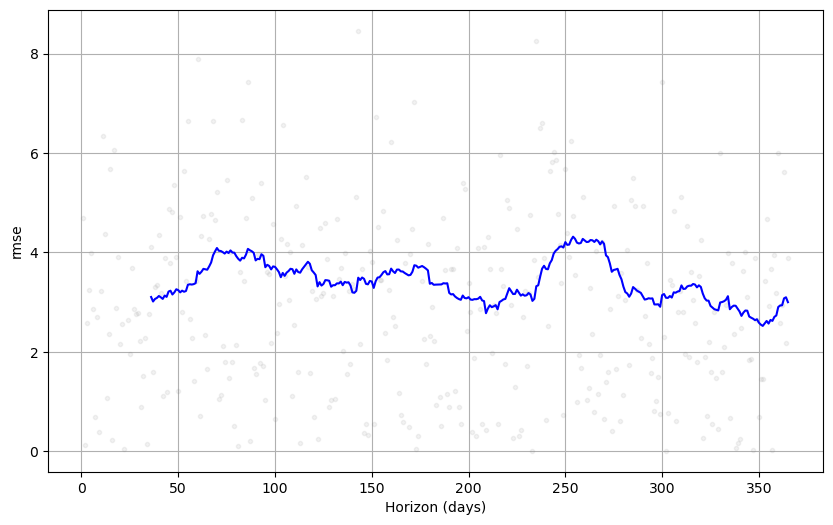

In [160]:
initial = '364 days'  
period = '360 days'   
horizon = '365 days' 


cv_results = cross_validation(electronics_sales_model, initial='364 days', period='360 days', horizon='365 days')
df_electronics_p = performance_metrics(cv_results)
print(df_p)


fig1 = plot_cross_validation_metric(cv_results, metric='mae')
fig2 = plot_cross_validation_metric(cv_results, metric='rmse')
plt.show()